In [62]:
import matplotlib.pyplot as plt
from datasets import load_dataset
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter
from transformers import pipeline
from datasets import load_dataset
import numpy as np

# Download necessary resources from nltk
# nltk.download('punkt')
# nltk.download('stopwords')

dataset = load_dataset("cnn_dailymail", '3.0.0')
df = dataset['train'].to_pandas()
df = df.head(1000)



def preprocess_text(text):
    # Tokenize text
    tokens = word_tokenize(text)
    # Convert to lower case
    tokens = [token.lower() for token in tokens]
    # Remove stop words (optional)
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words and token.isalpha()]
    return " ".join(tokens)

###====== Part 2.1 =====================
###Write a code that creates two new columns -  artice_len and highlights_len
df['article_len'] = [len(df['article'][i]) for i in range(len(df['article']))]
df['highlight_len'] = [len(df['highlights'][i]) for i in range(len(df['highlights']))]

###====== Part 2.2 =====================
### Fill in this code
def plot_histograms(df):
    p = plt.figure(figsize=(10, 6))
    sns.histplot(data=df['article_len'], alpha=0.5, label='Distribution 1', color='blue')
    sns.histplot(data=df['highlight_len'], alpha=0.5, label='Distribution 1', color='green')
    plt.legend(['article_len','highlight_len'])
    plt.title('Histogram of cnn_dailymail')
    plt.show()
    return p

# plot_histograms(df)

###======Part 2.3 ================
### Fill in the code
def ngrams(text, n):
    # Preprocess the text first
    processed_text = preprocess_text(text)
    words = processed_text.split()
    return set(zip(*[words[i:] for i in range(n)]))


def rouge_n(reference, candidate, n):
    # Generate n-grams
    ref_ngrams = ngrams(reference,n) # summary
    cand_ngrams = ngrams(candidate,n) # article
    
    if not ref_ngrams or not cand_ngrams:
        return 0.0
    
    # Count n-grams
    ref_ngram_counts = Counter(ref_ngrams)
    cand_ngram_counts = Counter(cand_ngrams)
    
     # Find overlapping n-grams
    overlap = 0
    for ngram in ref_ngram_counts:
        overlap += min(ref_ngram_counts[ngram], cand_ngram_counts[ngram])
    
    # Calculate recall
    recall = overlap / sum(ref_ngram_counts.values())
    
    # Calculate precision
    precision = overlap / sum(cand_ngram_counts.values())
    
    # Calculate F1 score
    if precision + recall == 0:
        return 0.0
    f1 = 2 * (precision * recall) / (precision + recall)
    
    return f1
# print(rouge_n(df['article'][0]))
# print(rouge_n(df['article'][0], df['highlight'][0], 2))

###=========== 2.3 ================    

# Example of calculating Rouge-1 and Rouge-2 for a dataframe
# df['rouge_1'] = df.apply(lambda row: rouge_n(row['highlights'], row['article'], 1), axis=1)
# df['rouge_2'] = df.apply(lambda row: rouge_n(row['highlights'], row['article'], 2), axis=1)

# plt.figure(figsize=(12, 6))
# plt.hist(df['rouge_2'], bins=30, color='blue', alpha=0.7)
# plt.title('Rouge-2 score distribution on ground truth')
# plt.show()

# max_rouge_2_index = df['rouge_2'].argmin()
# print(max_rouge_2_index)


# print("Index of article with highest Rouge-2 score:", max_rouge_2_index)
# print("\n score:", df['rouge_2'][max_rouge_2_index])
# print("========================\n")
# print("Article with highest Rouge-2 score:", df.iloc[max_rouge_2_index]['article'])
# print("========================\n\n\n")
# print("Highlights with highest Rouge-2 score:", df.iloc[max_rouge_2_index]['highlights'])



###=========== 2.4 ================    
# Initialize the summarization pipeline
summarizer = pipeline("summarization", model="t5-small", device=1)


def summarize_text(text):

    # Summarizing the text using the pipeline
    summary = summarizer(text, max_length=20, min_length=5, do_sample=False)
    print("-")
    n=2
    return summary[0]['summary_text']


# print('\n')
# print(df['article'][883])
# print('The generated summary is')
# print(generated_summary)



## Is there an instance where the score is lower than on the ground truth?
 

 # check the ngram score of the entire dataset
 # compare it with the score of the 


/opt/anaconda3/envs/ml_env/lib/python3.8/site-packages/transformers/pytorch_utils.py:325: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_elements = torch.tensor(test_elements)


-


(CNN) -- A year ago Thursday, I-Report was born. CNN.com launched its I-Report initiative August 2, 2006, in an effort to involve citizens in the newsgathering process. Numerous milestones later, I-Report has grown and developed its ability to be an integral component of the network's coverage. Mark Lacroix photographed the collapsed bridge from his apartment window. On the eve of its anniversary, I-Reporters responded to yet another major news event: the deadly collapse of a bridge over the Mississippi river in Minneapolis, Minnesota. Mark Lacroix sent photos of the scene immediately after the disaster. As the story developed, he provided information about the situation to viewers live on television. Lacroix's photos were among the more than 450 I-Report submissions sent to CNN within the first 24 hours of the bridge's collapse -- the biggest response in one day to a single news event in I-Report history. CNN.com readers have long been submitting photos and video, as well as speak

In [ ]:

 # ... existing code ...

def compare_summaries(df, start=0,num_samples=5):
    results = []
    for i in range(start,num_samples):
        # Generate summary
        generated_summary = summarize_text(df['article'].iloc[i])
        
        # Calculate ROUGE scores for both generated and ground truth summaries
        generated_rouge2 = rouge_n(generated_summary, df['article'].iloc[i], 2)
        ground_truth_rouge2 = rouge_n(df['highlights'].iloc[i], df['article'].iloc[i], 2)
        result ={
            'index': i,
            'generated_rouge2': generated_rouge2,
            'ground_truth_rouge2': ground_truth_rouge2,
            'is_lower': generated_rouge2 < ground_truth_rouge2
        }
        results.append(result)
    
        if i%100==0:
            print(i)
        # if result['is_lower']:
        #     print(i)
        #     print(f"Article {result['index']}:")
        #     print(f"Generated summary ROUGE-2: {result['generated_rouge2']}")
        #     print(f"Ground truth ROUGE-2: {result['ground_truth_rouge2']}")
        #     # print(f"Generated score is lower: {result['is_lower']}\n")

    return results

# Compare the summaries




In [63]:
z = compare_summaries(df, start=0,num_samples=10)


Token indices sequence length is longer than the specified maximum sequence length for this model (638 > 512). Running this sequence through the model will result in indexing errors
/opt/anaconda3/envs/ml_env/lib/python3.8/site-packages/transformers/pytorch_utils.py:325: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_elements = torch.tensor(test_elements)


-
0
-
-
-
-
-
-
-
-
-


In [66]:
import pandas as pd
a = pd.DataFrame(z)


In [67]:
a

,index,generated_rouge2,ground_truth_rouge2,is_lower
0,0,0.050209,0.155642,True
1,1,0.035503,0.050420,True
2,2,0.012195,0.040230,True
3,3,0.041841,0.039683,False
4,4,0.019960,0.026565,True
5,5,0.011080,0.026525,True
6,6,0.015190,0.028571,True
7,7,0.061538,0.132075,True
8,8,0.038023,0.057971,True
9,9,0.023256,0.043011,True


In [20]:
r1 = compare_summaries(df, start=0,num_samples=300)


-
0
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
100
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
200
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-


In [50]:
x1 = [1 if r1[i]['is_lower'] == True else 0 for i in range(len(r1))]

# import matplotlib.pyplot as plt
# plt.hist(x)
# plt.show()
sum(x1)

235

In [51]:
r2 = compare_summaries(df, start=300,num_samples=600)


/opt/anaconda3/envs/ml_env/lib/python3.8/site-packages/transformers/pytorch_utils.py:325: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_elements = torch.tensor(test_elements)


-
300
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
400
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
500
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-


In [52]:
x2 = [1 if r2[i]['is_lower'] == True else 0 for i in range(len(r2))]
sum(x2)

246

In [55]:
r3 = compare_summaries(df, start=600,num_samples=800)


-
600
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
700
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-


In [56]:
x3 = [1 if r3[i]['is_lower'] == True else 0 for i in range(len(r3))]
sum(x3)

167

In [57]:

r4 = compare_summaries(df, start=800,num_samples=1000)


-
800
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
900
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-


In [58]:
x4 = [1 if r4[i]['is_lower'] == True else 0 for i in range(len(r4))]
sum(x4)

149

Text(0.5, 1.0, 'Is the Score lower than the ground truth?')

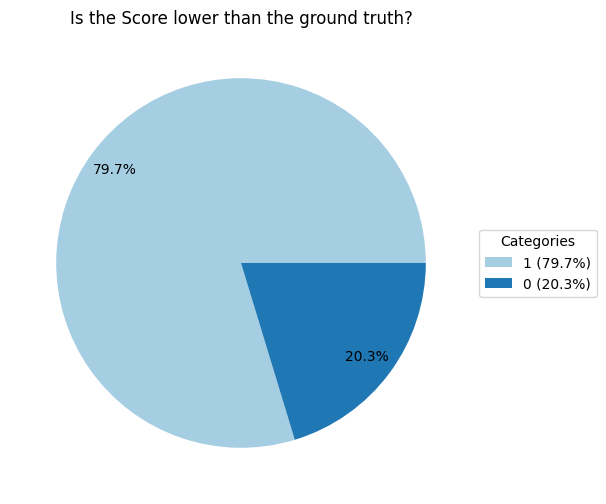

In [60]:
x = [1]*797 + [0]*203
values, counts = np.unique(x, return_counts=True)
sorted_pairs = sorted(zip(counts, values), reverse=True)  # legend by frequency
sizes_sorted, labels_sorted = zip(*sorted_pairs)

# Calculate percentages
total = sum(sizes_sorted)
percentages = [count/total * 100 for count in sizes_sorted]

# Create labels with percentages for legend
labels_with_pct = [f'{label} ({pct:.1f}%)' for label, pct in zip(labels_sorted, percentages)]

colors = sns.color_palette("Paired", len(counts))  # no repeating colors
plt.figure(figsize=(16, 6))  # Make the plot wider

# Add autopct parameter to display percentages on the pie chart
plt.pie(sizes_sorted, 
        colors=colors, 
        autopct='%1.1f%%',  # Display percentages on pie slices
        pctdistance=0.85)   # Adjust distance of percentage labels from center

plt.legend(labels_with_pct,  # Use new labels with percentages
          title="Categories",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))  # place legend outside

plt.title('Is the Score lower than the ground truth?')